## Import Packages

In [4]:

import matplotlib.pyplot as plt
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
import numpy as np
import PIL
import torch
from PIL import Image
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from itertools import chain
from os import listdir
from os.path import isfile, join
import random
import seaborn as sns 
PIL.Image.MAX_IMAGE_PIXELS = 241591910490
%matplotlib inline

#### Channels:
- FITC/525 nm : SYTO 13 : DNA (Grey)
- Cy3/568 nm : Alexa 532 : PanCK (Yellow)
- Texas Red/615 nm : Alexa 594 : CD45 (Cyan)
- Cy5/666 nm : Cy5 : Custom (Magenta)

**SYTO** Deep Red Nucleic Acid Stain is cell-permeant dye that specifically stains the nuclei of live, dead, or fixed cells.

**pan-CK** (AE1/AE3) and EMA are epithelium-specific antibodies. As the basic component of cellular structure of normal epithelial cells and epithelial cancer cells, they are often used to differentiate tumors according to whether they originate from the epithelium or not.

**CD45** is a signalling molecule that is an essential regulator of T and B cell antigen receptor signalling.
**CD10+CD31** – Proximal nephrons and endothelial cells (Custom)

# Neural Network with Different Splits of Training, Test and Validation Data

The below code is used to run the neural network on different splits of training, test and validation data. It then determines a mean performance of the perfomance indicators. For seperate steps of running the code, please refer to the Step by Step Process section.

### Initialize Input Parameters for Training and Testing Multiple Dataset Splits

In [5]:
#Number of Patches
n_patches=36
#Number of Epochs
num_epochs=20
#Iterations of different set splits
n_splits=3
#Learning Rate
learning_rate=1e-4

#Set path for image files
#geomx
path_to_geomx_images = "/scratch/st-singha53-1/datasets/geomx/dkd/ometif/"
#hne
path_to_hne_images = "/scratch/st-singha53-1/datasets/geomx/dkd/hne/"
#onlyfiles = [f for f in listdir(path_to_images) if isfile(join(path_to_images, f))]



### Image Processing Function

In [6]:
def process_image(path_to_images, x, group, ref_group, n_patches):
    PATCH_SIZE = 227
    f = int(np.sqrt(n_patches))
    IMG_SIZE = PATCH_SIZE * f
    resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
    transform = transforms.Compose([transforms.ToTensor()])
    ## import image
    img = Image.open(path_to_images+x).convert('RGB')
    ## convert img to tensor
    img = transform(img)
    ## resize image
    resized_img = resize(img)
    ## create patches
    patches = resized_img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
    dataset=[]
    ## reshape data
    for i in range(f):
        for j in range(f):
            sub_img = patches[:, i, j]
            if group == ref_group:
                data_target = (sub_img, 0)
            else:
                data_target = (sub_img, 1)
            dataset.append(data_target)
    return dataset

### Function/Class to Create Datasets with Patches

In [7]:
def create_datasets(dict_images={}, n_patches=36, ref_group = 'normal', path_to_images=[]):
    images = {}
    for group in dict_images.keys():
        for sample in dict_images[group]:
            path = path_to_images+sample+"/"
            onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
            l = [process_image(path, x, group, ref_group, n_patches) for x in onlyfiles]
            flat_list = [item for sublist in l for item in sublist]
            images[group] = flat_list
    return images

class Custom_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, _dataset):
        self.dataset = _dataset

    def __getitem__(self, index):
        example, target = self.dataset[index]
        return example, target

    def __len__(self):
        return len(self.dataset)

### Function to Train and Test Model 

In [8]:
def train_model(train,valid,test,path,n_patches,learning_rate,num_epochs):

    # Create and load Datasets 
    
    #print("train loader")
    train_datasets = create_datasets(dict_images = train, n_patches = n_patches, ref_group = 'normal', path_to_images=path)
    train_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(train_datasets['dkd'] + train_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)
    #print("validation loader")
    valid_datasets = create_datasets(dict_images = valid, n_patches = n_patches, ref_group = 'normal', path_to_images=path)
    valid_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(valid_datasets['dkd'] + valid_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)
    #print("test loader")
    test_datasets = create_datasets(dict_images = test, n_patches = n_patches, ref_group = 'normal', path_to_images=path)
    test_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(test_datasets['dkd'] + test_datasets['normal']),
                                           batch_size=1, shuffle=False)
    
    
    
    
    
    #initialize model
    
    from torch import nn, optim
    from torchvision import models

    #Hyperparameters
    in_channel = 3 
    num_classes = 2 

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    torch.manual_seed(0)
    np.random.seed(0)
    
    #load neural network model
    net = models.alexnet()
    net.load_state_dict(torch.load('/scratch/st-singha53-1/pthanga/geomx2rna/patrick/my_jupyter/alexnet-owt-4df8aa71.pth'))
    
    #set outputs of neural network to 2
    net.classifier[6] = nn.Linear(4096, 2) 
    
    #freezes model
    for param in net.parameters():
        param.requires_grad = False
        
    #set requirements for the last layer of classifier to have weights
    net.classifier[6].weight.requires_grad = True
    net.classifier[6].bias.requires_grad = True
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    
    
    
    
    
    #Train Model
    def accuracy(out, labels):
        _,pred = torch.max(out, dim=1)
        return torch.sum(pred==labels).item()

    net.to(device)
    net.train()
    
    #set number of epochs
    n_epochs = num_epochs
    print_every = 10
    
    #set minimum validation loss
    valid_loss_min = np.Inf
    
    #initialize validation loss, accuracy and train loss and accuracy arrays
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    
    #set total amount of steps in the datasets
    total_step = len(train_loader)
    
    #train data for a number of epochs(an epoch is a pass of data through the network)
    for epoch in range(1, n_epochs+1):
        
        #set running loss, correct prediction and total predictions to 0
        running_loss = 0.0
        correct = 0
        total=0
        
        #print(f'Epoch {epoch}\n')
        
        #training
        for batch_idx, (data_, target_) in enumerate(train_loader):
            
            #load data to device
            data_, target_ = data_.to(device), target_.to(device)
            
            #determine outputs from inputting data in neural network
            outputs = net(data_)
            
            #determine loss function
            loss = criterion(outputs, target_)
            
            #backpropogation
            loss.backward()
            
            #perform a parameter update based on current gradient 
            optimizer.step()
            
            #set optimizer gradient to zero
            optimizer.zero_grad()
            
            #calculate running loss
            running_loss += loss.item()
            
            #determine prediction value
            _,pred = torch.max(outputs, dim=1)
            
            #count correct predictions
            correct += torch.sum(pred==target_).item()
            
            #determine total predictions
            total += target_.size(0)
            #if (batch_idx) % 20 == 0:
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  # .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
                
        #record the training accuracy and training loss
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        #print(f'\\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        
        #set batch, correct prediction and total predictions to 0
        batch_loss = 0
        total_t=0
        correct_t=0
        
        # validation
        with torch.no_grad():
            
            #set network into evaluation mode
            net.eval()
            
            #running the neural network through the validation dataset
            for data_t, target_t in (valid_loader):
                
                #load data and targets onto device
                data_t, target_t = data_t.to(device), target_t.to(device)
                
                #run network on data to optain outputs
                outputs_t = net(data_t)
                
                #calculate loss
                loss_t = criterion(outputs_t, target_t)
                
                #calculate batch loss
                batch_loss += loss_t.item()
                
                #determine prediction
                _,pred_t = torch.max(outputs_t, dim=1)
                
                #count correct prediction
                correct_t += torch.sum(pred_t==target_t).item()
                
                #determine the total amount of predictions/targets 
                total_t += target_t.size(0)
                
            #Calculate the validation accuracy and validation loss
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(valid_loader))
            
            #sets the network learned condition if the current batch loss is less than the minimum validation loss
            network_learned = batch_loss < valid_loss_min
            #print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\\n')


            if network_learned:
                #set the batch loss as  minimum validation loss 
                valid_loss_min = batch_loss
                #Saving the model
                torch.save(net.state_dict(), 'model.pt')
                #print('Improvement-Detected, save-model')
                
        #set network to training mode
        net.train()
        
        
        
    
    
    
        
    #Test Model
    
    #Softmax function to convert to probabilites(https://pytorch.org/hub/pytorch_vision_alexnet/)
    m = nn.Softmax(dim=1)
    
    #initialize values
    total_t=0
    correct_t=0
    tp=0
    fp=0
    fn=0
    tn=0
    target=[]
    prob=[]
    

    with torch.no_grad():
        #sets model into evaluation mode
        net.eval()
        for data_t, target_t in (test_loader):
            #initialize test data
            data_t, target_t = data_t.to(device), target_t.to(device)
            #run data through the neural network 
            outputs_t = net(data_t)
            #determine the predicted diagnosis by selecting the highest prediciton score
            _,pred_t = torch.max(outputs_t, dim=1)
            #store target values
            target.append(target_t.item())
            
            #convert predictions to probabilities for ROC calculations 
            prediction=outputs_t
            #add probabilities to list
            prob.append(prediction.tolist())
            
        
            #Count correct predictions
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)

            #Determine true and false positives and negative for threshold of 0.5
            fp += np.sum((pred_t.item() == 1) & (target_t.item() == 0))
            tp += np.sum((pred_t.item() == 1) & (target_t.item() == 1))
            fn += np.sum((pred_t.item() == 0) & (target_t.item() == 1))
            tn += np.sum((pred_t.item() == 0) & (target_t.item() == 0))
            
    
    #Calculate ROC and AUC metrics
    #create array from probability list
    roc=np.array(list(chain(*prob)))
    
    # Area Under the Curve Calculation

    lr_auc = roc_auc_score(target, roc[:,1])
    #False Positive rate values, True positive rate values for different thresholds
    lr_fpr, lr_tpr, threshold = roc_curve(target, roc[:,1])
    

    #True and False Positive rates for a threshold of 0.5
    fpr=(fp/(fp+tn))
    tpr=(tp/(tp+fn))



    #Accuracy 
    acc=correct_t/total_t
    #print(100 * correct_t/total_t)
    
    #Fscore
    Fscore=tp/(tp+1/2*(fp+fn))

    

    return lr_auc,acc,fpr,tpr

## Loop for Training and Testing Neural Network on Dataset Splits

In [9]:

#Number of Random Split combinations
n=n_splits+1

#initialize arrays to store the performance indicators
geomx=np.zeros((n-1,4))
hne=np.zeros((n-1,4))

#Datasets
#Diabetic Kidney Samples
dkd=['disease1B_scan', 'disease4_scan','disease3_scan','disease2B_scan']
#Normal Kidney Samples
norm=['normal2B_scan','normal4_scan','normal3_scan']

# Training and Testing Datasets
for i in range(1,n):
    #random sampling for data splits
    dkd_list = random.sample(dkd, 4)
    norm_list = random.sample(norm, 3)
    train = {'dkd': [dkd_list[0], dkd_list[1]],
             'normal': [norm_list[0]]}
    valid = {'dkd': [dkd_list[2]],
             'normal': [norm_list[1]]}
    test = {'dkd': [dkd_list[3]],
            'normal': [norm_list[2]]}

    #Train and test model
    geomx[i-1,:]=train_model(train,valid,test,path_to_geomx_images,n_patches,learning_rate,num_epochs)
    hne[i-1,:]=train_model(train,valid,test,path_to_hne_images,n_patches,learning_rate,num_epochs)
    
    
#Take Average of all scores for each indicator (Area under ROC curve, accuracy, false positive rate, true positive rate)    
geomx_avgauc,geomx_avgacc,geomx_avgfpr,geomx_avgtpr=np.mean(geomx[:,0]),np.mean(geomx[:,1]),np.mean(geomx[:,2]),np.mean(geomx[:,3])
hne_avgauc,hne_avgacc,hne_avgfpr,hne_avgtpr=np.mean(hne[:,0]),np.mean(hne[:,1]),np.mean(hne[:,2]),np.mean(hne[:,3])

#standard deviations for each indicator
geomx_stdauc,geomx_stdacc,geomx_stdfpr,geomx_stdtpr=np.std(geomx[:,0]),np.std(geomx[:,1]),np.std(geomx[:,2]),np.std(geomx[:,3])
hne_stdauc,hne_stdacc,hne_stdfpr,hne_stdtpr=np.std(hne[:,0]),np.std(hne[:,1]),np.std(hne[:,2]),np.std(hne[:,3])




## Plot Results

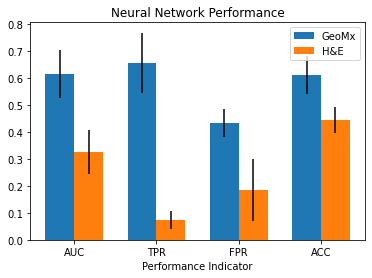

In [10]:
#creating dataset for plotting                                    
d ={'method':['geomx','geomx','geomx','geomx', 'H&E','H&E','H&E','H&E'],
   'metrics':['AUC', 'TPR', 'FPR', 'ACC','AUC', 'TPR', 'FPR', 'ACC' ],
   'value':[geomx_avgauc,geomx_avgtpr,geomx_avgfpr,geomx_avgacc,hne_avgauc,hne_avgtpr,hne_avgfpr,hne_avgacc],
   'std':[geomx_stdauc,geomx_stdtpr,geomx_stdfpr,geomx_stdacc,hne_stdauc,hne_stdtpr,hne_stdfpr,hne_stdacc]}



#Plot geomx data
geomx_means = [geomx_avgauc,geomx_avgtpr,geomx_avgfpr,geomx_avgacc]
geomx_std = [geomx_stdauc,geomx_stdtpr,geomx_stdfpr,geomx_stdacc]

fig, ax = plt.subplots()

N = 4 # number of x locations
ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
ax.bar(ind, geomx_means, width, bottom=0, yerr=geomx_std, label='GeoMx')

#Plot hne data
hne_means = [hne_avgauc,hne_avgtpr,hne_avgfpr,hne_avgacc]
hne_std = [hne_stdauc,hne_stdtpr,hne_stdfpr,hne_stdacc]
ax.bar(ind + width, hne_means, width, bottom=0, yerr=hne_std,
       label='H&E')

#Plot labels, setting and title
ax.set_xlabel("Performance Indicator")
ax.set_title('Neural Network Performance')
ax.set_xticks(ind + width / 2, labels=['AUC', 'TPR', 'FPR', 'ACC'])
ax.legend()
ax.autoscale_view()
plt.show()

# Step by Step Process

The below code is the step by step process for binary prediction of Geomx and HNE images.

#### Image Processing Function

In [11]:
def process_image(path_to_images, x, group, ref_group, n_patches):
    PATCH_SIZE = 227
    f = int(np.sqrt(n_patches))
    IMG_SIZE = PATCH_SIZE * f
    resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
    transform = transforms.Compose([transforms.ToTensor()])
    ## import image
    img = Image.open(path_to_images+x).convert('RGB')
    ## convert img to tensor
    img = transform(img)
    ## resize image
    resized_img = resize(img)
    ## create patches
    patches = resized_img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
    dataset=[]
    ## reshape data
    for i in range(f):
        for j in range(f):
            sub_img = patches[:, i, j]
            if group == ref_group:
                data_target = (sub_img, 0)
            else:
                data_target = (sub_img, 1)
            dataset.append(data_target)
    return dataset

#### Creating Dataset Function 

In [12]:
def create_datasets(dict_images={}, n_patches=36, ref_group = 'normal', path_to_images=[]):
    images = {}
    for group in dict_images.keys():
        for sample in dict_images[group]:
            path = path_to_images+sample+"/"
            onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
            l = [process_image(path, x, group, ref_group, n_patches) for x in onlyfiles]
            flat_list = [item for sublist in l for item in sublist]
            images[group] = flat_list
    return images

class Custom_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, _dataset):
        self.dataset = _dataset

    def __getitem__(self, index):
        example, target = self.dataset[index]
        return example, target

    def __len__(self):
        return len(self.dataset)

#### Determining Training, Validation and Test Splits

In [13]:
train = {'dkd': ['disease1B_scan', 'disease4_scan'],
         'normal': ['normal3_scan']}
valid = {'dkd': ['disease3_scan'],
         'normal': ['normal4_scan']}
test = {'dkd': ['disease2B_scan'],
        'normal': ['normal2B_scan']}

## GeoMx Images

#### Initialize Neural Network

In [14]:
from torch import nn, optim
from torchvision import models

# Hyperparameters
in_channel = 3 
num_classes = 2 
learning_rate = 1e-4 
num_epochs = 40

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
torch.manual_seed(0)
np.random.seed(0)

net = models.alexnet()

net.load_state_dict(torch.load('/scratch/st-singha53-1/pthanga/geomx2rna/patrick/my_jupyter/alexnet-owt-4df8aa71.pth'))

#set model outputs to 2(binary output)
net.classifier[6] = nn.Linear(4096, 2) 

#freeze layers of the neural network
for param in net.parameters():
    param.requires_grad = False

#set requirements for the last layer of classifier to have weights    
net.classifier[6].weight.requires_grad = True
net.classifier[6].bias.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#### Load Data

In [15]:
path_to_images = "/scratch/st-singha53-1/datasets/geomx/dkd/ometif/"


print("train loader")
train_datasets = create_datasets(dict_images = train, n_patches = 36, ref_group = 'normal', path_to_images=path_to_images)
train_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(train_datasets['dkd'] + train_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)
print("validation loader")
valid_datasets = create_datasets(dict_images = valid, n_patches = 36, ref_group = 'normal', path_to_images=path_to_images)
valid_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(valid_datasets['dkd'] + valid_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)
print("test loader")
test_datasets = create_datasets(dict_images = test, n_patches = 36, ref_group = 'normal', path_to_images=path_to_images)
test_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(test_datasets['dkd'] + test_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)

train loader
validation loader
test loader


#### Training

In [16]:
#Train Model
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

net.to(device)
net.train()

#set number of epochs
n_epochs = 40
print_every = 10

#set minimum validation loss
valid_loss_min = np.Inf

#initialize validation loss, accuracy and train loss and accuracy arrays
val_loss = []
val_acc = []
train_loss = []
train_acc = []

#set total amount of steps in the datasets
total_step = len(train_loader)

#train data for a number of epochs(an epoch is a pass of data through the network)
for epoch in range(1, n_epochs+1):

    #set running loss, correct prediction and total predictions to 0
    running_loss = 0.0
    correct = 0
    total=0

    #print(f'Epoch {epoch}\n')

    #training
    for batch_idx, (data_, target_) in enumerate(train_loader):

        #load data to device
        data_, target_ = data_.to(device), target_.to(device)

        #determine outputs from inputting data in neural network
        outputs = net(data_)

        #determine loss function
        loss = criterion(outputs, target_)

        #backpropogation
        loss.backward()

        #perform a parameter update based on current gradient 
        optimizer.step()

        #set optimizer gradient to zero
        optimizer.zero_grad()

        #calculate running loss
        running_loss += loss.item()

        #determine prediction value
        _,pred = torch.max(outputs, dim=1)

        #count correct predictions
        correct += torch.sum(pred==target_).item()

        #determine total predictions
        total += target_.size(0)
        #if (batch_idx) % 20 == 0:
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              # .format(epoch, n_epochs, batch_idx, total_step, loss.item()))

    #record the training accuracy and training loss
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    #print(f'\\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    #set batch, correct prediction and total predictions to 0
    batch_loss = 0
    total_t=0
    correct_t=0

    # validation
    with torch.no_grad():

        #set network into evaluation mode
        net.eval()

        #running the neural network through the validation dataset
        for data_t, target_t in (valid_loader):

            #load data and targets onto device
            data_t, target_t = data_t.to(device), target_t.to(device)

            #run network on data to optain outputs
            outputs_t = net(data_t)

            #calculate loss
            loss_t = criterion(outputs_t, target_t)

            #calculate batch loss
            batch_loss += loss_t.item()

            #determine prediction
            _,pred_t = torch.max(outputs_t, dim=1)

            #count correct prediction
            correct_t += torch.sum(pred_t==target_t).item()

            #determine the total amount of predictions/targets 
            total_t += target_t.size(0)

        #Calculate the validation accuracy and validation loss
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))

        #sets the network learned condition if the current batch loss is less than the minimum validation loss
        network_learned = batch_loss < valid_loss_min
        #print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\\n')


        if network_learned:
            #set the batch loss as  minimum validation loss 
            valid_loss_min = batch_loss
            #Saving the model
            torch.save(net.state_dict(), 'model.pt')
            #print('Improvement-Detected, save-model')

    #set network to training mode
    net.train()
        

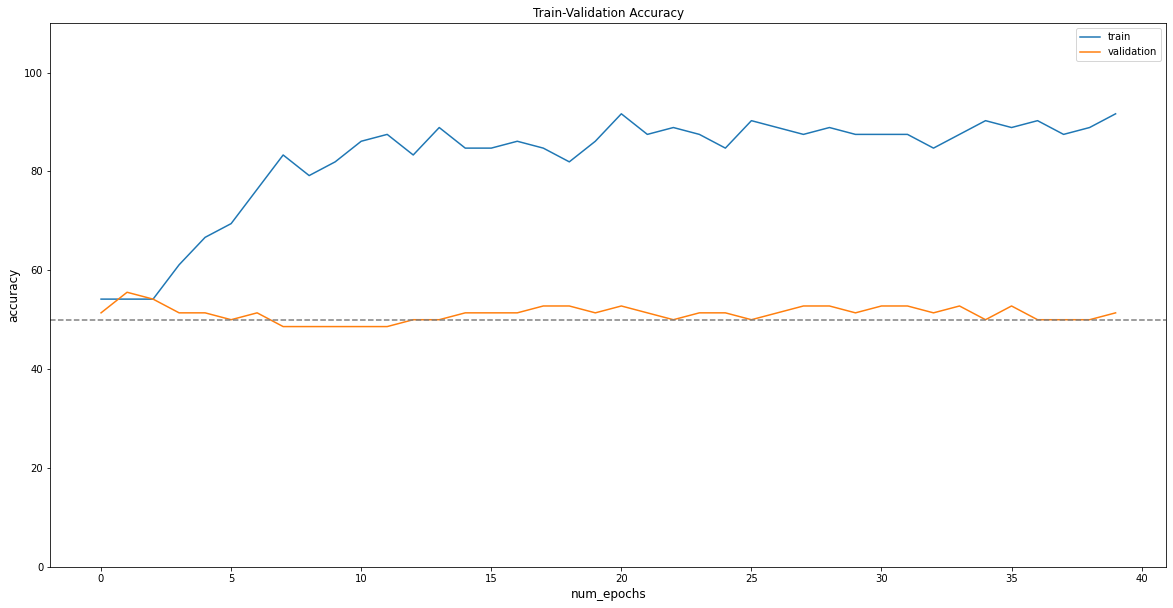

In [17]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.ylim(0,110)
plt.axhline(y=50, color='gray', linestyle='--')

#### Test Accuracy

In [18]:

#Test Model
    
#Softmax function
m = nn.Softmax(dim=1)

#initialize values
total_t=0
correct_t=0
tp=0
fp=0
fn=0
tn=0
target=[]
prob=[]


with torch.no_grad():
    #sets model into evaluation mode
    net.eval()
    for data_t, target_t in (test_loader):
        #initialize test data
        data_t, target_t = data_t.to(device), target_t.to(device)
        #run data through the neural network 
        outputs_t = net(data_t)
        #determine the predicted diagnosis by selecting the highest prediciton score
        _,pred_t = torch.max(outputs_t, dim=1)
        #store target values
        target.append(target_t.item())

        #convert predictions to probabilities for ROC calculations 
        prediction =outputs_t
        #add probabilities to list
        prob.append(prediction.tolist())


        #Count correct predictions
        correct_t += torch.sum(pred_t==target_t).item()

        total_t += target_t.size(0)
        #Determine true and false positives and negative for threshold of 0.5
        fp += np.sum((pred_t.item() == 1) & (target_t.item() == 0))
        tp += np.sum((pred_t.item() == 1) & (target_t.item() == 1))
        fn += np.sum((pred_t.item() == 0) & (target_t.item() == 1))
        tn += np.sum((pred_t.item() == 0) & (target_t.item() == 0))


#Calculate ROC and AUC metrics
roc=np.array(list(chain(*prob)))

# Area under reciever operating curve 
geomx_auc = roc_auc_score(target, roc[:,1])
#False Positive rate values, True positive rate values for different thresholds
geomx_fprs, geomx_tprs, threshold = roc_curve(target, roc[:,1])


#True and False Positive rates for a threshold of 0.5
geomx_fpr=(fp/(fp+tn))
geomx_tpr=(tp/(tp+fn))



#Accuracy 
geomx_acc=correct_t/total_t

#Fscore
geomx_Fscore=tp/(tp+1/2*(fp+fn))






## H&E Images

#### Initialize Neural Network

In [19]:
from torch import nn, optim
from torchvision import models

# Hyperparameters
in_channel = 3 
num_classes = 2 
learning_rate = 1e-4 
num_epochs = 40

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
torch.manual_seed(0)
np.random.seed(0)

net = models.alexnet()

net.load_state_dict(torch.load('/scratch/st-singha53-1/pthanga/geomx2rna/patrick/my_jupyter/alexnet-owt-4df8aa71.pth'))

#set model outputs to 2(binary output)
net.classifier[6] = nn.Linear(4096, 2) 

#freeze layers of the neural network
for param in net.parameters():
    param.requires_grad = False

#set requirements for the last layer of classifier to have weights    
net.classifier[6].weight.requires_grad = True
net.classifier[6].bias.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [20]:
for param in net.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


#### Load Data

In [21]:
path_to_images = "/scratch/st-singha53-1/datasets/geomx/dkd/hne/"

print("train loader")
train_datasets = create_datasets(dict_images = train, n_patches = 36, ref_group = 'normal', path_to_images=path_to_images)
train_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(train_datasets['dkd'] + train_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)
print("validation loader")
valid_datasets = create_datasets(dict_images = valid, n_patches = 36, ref_group = 'normal', path_to_images=path_to_images)
valid_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(valid_datasets['dkd'] + valid_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)
print("test loader")
test_datasets = create_datasets(dict_images = test, n_patches = 36, ref_group = 'normal', path_to_images=path_to_images)
test_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(test_datasets['dkd'] + test_datasets['normal']),
                                           batch_size=1,
                                           shuffle=False)

train loader
validation loader
test loader


#### Training

In [22]:
#Train Model
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

net.to(device)
net.train()

#set number of epochs
n_epochs = 40
print_every = 10

#set minimum validation loss
valid_loss_min = np.Inf

#initialize validation loss, accuracy and train loss and accuracy arrays
val_loss = []
val_acc = []
train_loss = []
train_acc = []

#set total amount of steps in the datasets
total_step = len(train_loader)

#train data for a number of epochs(an epoch is a pass of data through the network)
for epoch in range(1, n_epochs+1):

    #set running loss, correct prediction and total predictions to 0
    running_loss = 0.0
    correct = 0
    total=0

    #print(f'Epoch {epoch}\n')

    #training
    for batch_idx, (data_, target_) in enumerate(train_loader):

        #load data to device
        data_, target_ = data_.to(device), target_.to(device)

        #determine outputs from inputting data in neural network
        outputs = net(data_)

        #determine loss function
        loss = criterion(outputs, target_)

        #backpropogation
        loss.backward()

        #perform a parameter update based on current gradient 
        optimizer.step()

        #set optimizer gradient to zero
        optimizer.zero_grad()

        #calculate running loss
        running_loss += loss.item()

        #determine prediction value
        _,pred = torch.max(outputs, dim=1)

        #count correct predictions
        correct += torch.sum(pred==target_).item()

        #determine total predictions
        total += target_.size(0)
        #if (batch_idx) % 20 == 0:
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
              # .format(epoch, n_epochs, batch_idx, total_step, loss.item()))

    #record the training accuracy and training loss
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    #print(f'\\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    #set batch, correct prediction and total predictions to 0
    batch_loss = 0
    total_t=0
    correct_t=0

    # validation
    with torch.no_grad():

        #set network into evaluation mode
        net.eval()

        #running the neural network through the validation dataset
        for data_t, target_t in (valid_loader):

            #load data and targets onto device
            data_t, target_t = data_t.to(device), target_t.to(device)

            #run network on data to optain outputs
            outputs_t = net(data_t)

            #calculate loss
            loss_t = criterion(outputs_t, target_t)

            #calculate batch loss
            batch_loss += loss_t.item()

            #determine prediction
            _,pred_t = torch.max(outputs_t, dim=1)

            #count correct prediction
            correct_t += torch.sum(pred_t==target_t).item()

            #determine the total amount of predictions/targets 
            total_t += target_t.size(0)

        #Calculate the validation accuracy and validation loss
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))

        #sets the network learned condition if the current batch loss is less than the minimum validation loss
        network_learned = batch_loss < valid_loss_min
        #print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\\n')


        if network_learned:
            #set the batch loss as  minimum validation loss 
            valid_loss_min = batch_loss
            #Saving the model
            torch.save(net.state_dict(), 'model.pt')
            #print('Improvement-Detected, save-model')

    #set network to training mode
    net.train()
        

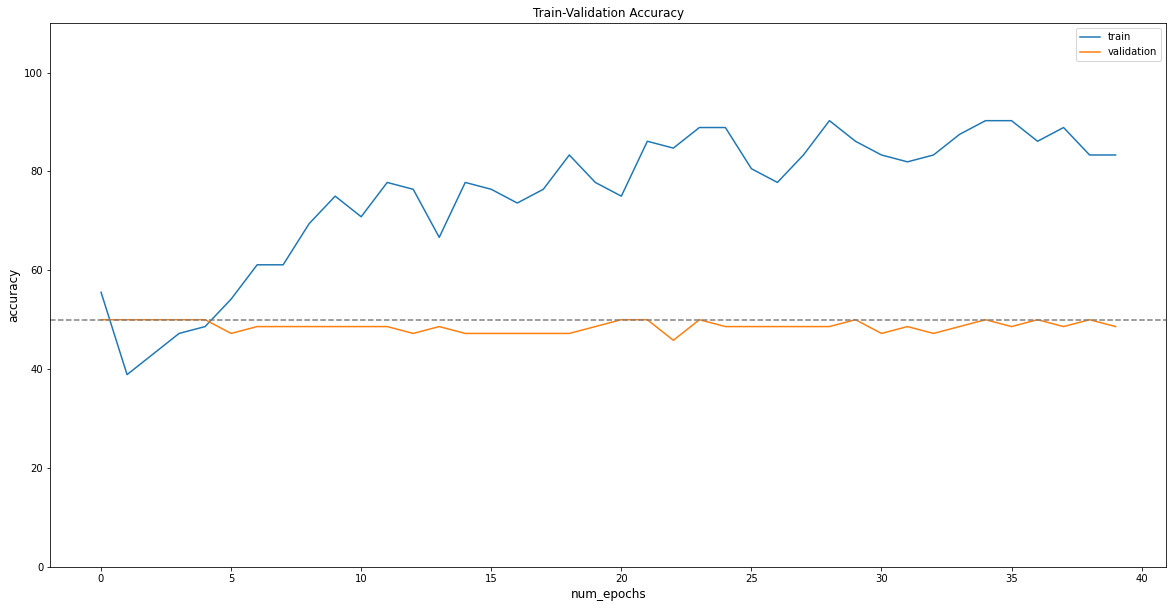

In [23]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.ylim(0,110)
plt.axhline(y=50, color='gray', linestyle='--')

#### Test Accuracy

In [24]:
#Test Model
    
#Softmax function
m = nn.Softmax(dim=1)

#initialize values
total_t=0
correct_t=0
tp=0
fp=0
fn=0
tn=0
target=[]
prob=[]


with torch.no_grad():
    #sets model into evaluation mode
    net.eval()
    for data_t, target_t in (test_loader):
        #initialize test data
        data_t, target_t = data_t.to(device), target_t.to(device)
        #run data through the neural network 
        outputs_t = net(data_t)
        #determine the predicted diagnosis by selecting the highest prediciton score
        _,pred_t = torch.max(outputs_t, dim=1)
        #store target values
        target.append(target_t.item())

        #convert predictions to probabilities for ROC calculations 
        prediction =outputs_t
        #add probabilities to list
        print(prediction)
        prob.append(prediction.tolist())


        #Count correct predictions
        correct_t += torch.sum(pred_t==target_t).item()

        total_t += target_t.size(0)
        print(pred_t.item(), target_t.item())
        #Determine true and false positives and negative for threshold of 0.5
        fp += np.sum((pred_t.item() == 1) & (target_t.item() == 0))
        tp += np.sum((pred_t.item() == 1) & (target_t.item() == 1))
        fn += np.sum((pred_t.item() == 0) & (target_t.item() == 1))
        tn += np.sum((pred_t.item() == 0) & (target_t.item() == 0))


#Calculate ROC and AUC metrics
roc=np.array(list(chain(*prob)))

# Area under reciever operating curve calculation
hne_auc = roc_auc_score(target, roc[:,1])
#False Positive rate values, True positive rate values for different thresholds
hne_fprs, hne_tprs, threshold = roc_curve(target, roc[:,1])


#True and False Positive rates for a threshold of 0.5
hne_fpr=(fp/(fp+tn))
hne_tpr=(tp/(tp+fn))



#Accuracy 
hne_acc=correct_t/total_t
print(100 * correct_t/total_t)

#Fscore
Fscore=tp/(tp+1/2*(fp+fn))






tensor([[-0.1104,  0.1762]])
1 1
tensor([[-0.1104,  0.1762]])
1 1
tensor([[-0.1762,  0.3123]])
1 1
tensor([[-0.5631,  0.6792]])
1 1
tensor([[-1.3221,  1.1522]])
1 1
tensor([[ 0.2327, -0.6329]])
0 1
tensor([[-1.3628,  0.8789]])
1 1
tensor([[ 0.2982, -0.7351]])
0 1
tensor([[ 1.0138, -0.6736]])
0 1
tensor([[ 1.0492, -0.3783]])
0 1
tensor([[ 1.5598, -0.9961]])
0 1
tensor([[ 1.1586, -1.2107]])
0 1
tensor([[0.5994, 0.0315]])
0 1
tensor([[ 1.1209, -0.4074]])
0 1
tensor([[ 1.1699, -0.4657]])
0 1
tensor([[ 1.9188, -1.5040]])
0 1
tensor([[ 2.0920, -1.5880]])
0 1
tensor([[ 1.3228, -1.3474]])
0 1
tensor([[ 0.7280, -0.9793]])
0 1
tensor([[0.6352, 0.1126]])
0 1
tensor([[ 1.4777, -0.6609]])
0 1
tensor([[ 1.0191, -0.3846]])
0 1
tensor([[ 1.7916, -2.0579]])
0 1
tensor([[-0.1104,  0.1762]])
1 1
tensor([[ 0.9826, -1.1653]])
0 1
tensor([[ 3.0682, -2.8086]])
0 1
tensor([[0.4943, 0.3101]])
0 1
tensor([[ 2.4134, -2.3520]])
0 1
tensor([[ 0.1220, -0.0701]])
0 1
tensor([[-0.1104,  0.1762]])
1 1
tensor([[-0.1104

## Plotting H\&E vs GeoMx

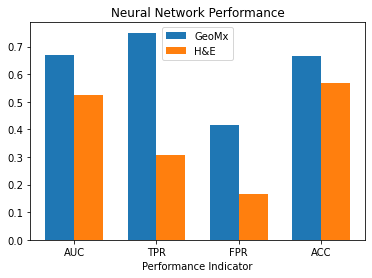

In [25]:
#creating dataset for plotting                                    
d ={'method':['geomx','geomx','geomx','geomx', 'H&E','H&E','H&E','H&E'],
   'metrics':['AUC', 'TPR', 'FPR', 'ACC','AUC', 'TPR', 'FPR', 'ACC' ],
   'value':[geomx_auc,geomx_tpr,geomx_fpr,geomx_acc,hne_auc,hne_tpr,hne_fpr,hne_acc]}

N = 4
geomx= [geomx_auc,geomx_tpr,geomx_fpr,geomx_acc]


fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
ax.bar(ind, geomx, width, bottom=0, label='GeoMx')

hne = [hne_auc,hne_tpr,hne_fpr,hne_acc]

ax.bar(ind + width, hne, width, bottom=0, label='H&E')
ax.set_xlabel("Performance Indicator")
ax.set_title('Neural Network Performance')
ax.set_xticks(ind + width / 2, labels=['AUC', 'TPR', 'FPR', 'ACC'])

ax.legend()

ax.autoscale_view()

plt.show()

## Baseline 
#### Results if the Neural Network predicted everything as positive

In [26]:
#baseline
#set initial values
tp=0
fp=0
fn=0

for data_t, target_t in (test_loader):
        data_t, target_t = data_t.to(device), target_t.to(device)
        #counts correct positive predictions
        correct_t += torch.sum(1==target_t).item()
        
        #identify true positive and false positive
        if target_t==1:
            tp +=1
        elif target_t !=1:
            fp+=1
            
        #determine total amount of predicitons/samples
        total_t += target_t.size(0)

#calculate f_score and accuracy
Accuracy=correct_t/total_t
Fscore=tp/(tp+1/2*(fp+fn))

